# Notebook to evaluate and compare tuning the GA hyperparameters

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
from bioinfokit.analys import stat
import scipy.stats as stats
from mycolorpy import colorlist as mcp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf


In [2]:
def get_performance_metrics(ranked_file, full_analysis_file):
    ranked_data = pd.read_csv(ranked_file)
    ga_data = pd.read_csv(full_analysis_file)

    # get all unique polymers found up to and including convergence generation
    unique_poly = pd.DataFrame(data = ga_data['filename'].unique(), columns = ['polymer'])

    # make sure new df of unique polymers sorted by rank
    ranked_ga = unique_poly.merge(ranked_data, how='left', on='polymer')
    ranked_ga = ranked_ga.sort_values(by=['rank'], ascending=True, ignore_index=True)

    # CHAMPION - best rank achieved in ga run
    champion = ranked_ga.loc[0, 'rank']

    # COVERAGE - number of elite polymers (rank <= 100) found in ga run
    coverage = len(ranked_ga[ranked_ga['rank'] <= 100])

    # SPEEDUP - total possible calculations/number of calculations run (i.e. # unique polymers found)
    speedup = 100128/len(ranked_ga)

    perform_metrics = [champion, coverage, speedup]
    
    return(perform_metrics)

In [3]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = 'x-large' # fontsize of legend title


In [43]:
def plot_coverage_vs_speedup(x, y, xerr, yerr, save_fig_name, legend_title, labels, legend_outside=False):

    if legend_outside=False:
        fig, ax1 = plt.subplots(dpi=100)
    else:
        fig, ax1 = plt.subplots(figsize=(8, 4))

    points = []

    #colors = np.array(range(0, 100, len(x)))
    #colors = np.arange(len(x))
    colormap = mcp.gen_color(cmap='jet', n=len(x))
    
    '''ax1.errorbar(x, y, yerr=yerr, xerr = xerr, fmt='o', color='tab:purple',
        ecolor='silver', elinewidth=3, capsize=0)'''
    
    scatter_kwargs = {"zorder":100}
    error_kwargs = {"lw":.5, "zorder":0}

    ax1.errorbar(x, y, yerr=yerr, xerr = xerr, fmt='o', c='silver',
        ecolor='silver', elinewidth=2, capsize=0, **error_kwargs)

    for i in range(len(x)):
        scatter = ax1.scatter(x[i], y[i], c=colormap[i])
        points.append(scatter)

    ax1.set(ylim=0)

    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    
    ax1.set_xlabel('Speedup', fontsize=20)
    ax1.set_ylabel('Coverage', fontsize=20)

    ax1.grid(alpha=0.5)
    ax1.set_axisbelow(True)

    #legend1 = ax1.legend(handles= *scatter.legend_elements(), labels = labels, loc='upper right', title=legend_title)
    #legend1 = ax1.legend(*scatter.legend_elements(), loc='upper right', title=legend_title, frameon=False)
    if legend_outside == True:
        ax1.legend(points, labels, loc='center left', bbox_to_anchor=(1, 0.5), title=legend_title, frameon=False, fontsize=12)
        #fig.set_figheight(5)
        #fig.set_figwidth(6)
    else:
        ax1.legend(points, labels, loc='upper right', title=legend_title, frameon=False, fontsize=12)


    #ax1.add_artist(legend1)

    plt.tight_layout()

    plt.savefig(save_fig_name + '_coverage_vs_speedup.pdf', dpi=600)
    plt.savefig(save_fig_name + '_coverage_vs_speedup.png', dpi=600)

### Set path for ranked polymers for polarizability, optical bandgap, and solvation energy ratio

In [4]:
polar_ranked_file = '/ihome/ghutchison/dch45/ga_methods/hexamer_pool/data_files/ranked_polar.csv'
opt_bg_ranked_file = '/ihome/ghutchison/dch45/ga_methods/hexamer_pool/data_files/ranked_opt_bg.csv'
solv_eng_ranked_file = '/ihome/ghutchison/dch45/ga_methods/hexamer_pool/data_files/ranked_solv_eng.csv'

### Parameters to loop through

In [5]:
chem_properties = ['polar', 'opt_bg', 'solv_eng']
run_labels = ['A', 'B', 'C', 'D', 'E']

## Population Size

In [15]:
def pop_size_find_average_performance(param):

    pop_size_champions = []
    pop_size_coverage = []
    pop_size_speedup = []
    index_prop = []
    labels = []

    for prop in chem_properties:
        if prop == 'polar':
            ranked_file = polar_ranked_file
        elif prop == 'opt_bg':
            ranked_file = opt_bg_ranked_file
        else:
            ranked_file = solv_eng_ranked_file
        for x in run_labels:
            full_analysis_file = '../full_files/full_analysis_pop_size_%s_%s_%s.csv' % (param, prop, x)
            champion, coverage, speedup = get_performance_metrics(ranked_file, full_analysis_file)
            pop_size_champions.append(champion)
            pop_size_coverage.append(coverage)
            pop_size_speedup.append(speedup)
            index_prop.append(prop)
            labels.append(x)

    pop_size_champions_med = statistics.median(pop_size_champions)
    pop_size_coverage_med = statistics.median(pop_size_coverage)
    pop_size_speedup_med = statistics.median(pop_size_speedup)

    zipped = zip(labels, pop_size_champions, pop_size_coverage, pop_size_speedup)
    df_pop_size = pd.DataFrame(zipped, index = index_prop, columns = ['Run Label', 'Champion', 'Coverage', 'Speedup'])
    df_pop_size.to_csv('all_runs_performance/pop_size_performance_%s.csv' % (param))


    if len(pop_size_champions) != 15:
        return 'missing a run'

    return pop_size_champions_med, pop_size_coverage_med, pop_size_speedup_med

In [16]:
size_32_champion_med, size_32_coverage_med, size_32_speedup_med= pop_size_find_average_performance(32)
size_16_champion_med, size_16_coverage_med, size_16_speedup_med= pop_size_find_average_performance(16)
size_20_champion_med, size_20_coverage_med, size_20_speedup_med= pop_size_find_average_performance(20)
size_24_champion_med, size_24_coverage_med, size_24_speedup_med= pop_size_find_average_performance(24)
size_28_champion_med, size_28_coverage_med, size_28_speedup_med= pop_size_find_average_performance(28)
size_48_champion_med, size_48_coverage_med, size_48_speedup_med= pop_size_find_average_performance(48)
size_72_champion_med, size_72_coverage_med, size_72_speedup_med= pop_size_find_average_performance(72)
size_96_champion_med, size_96_coverage_med, size_96_speedup_med= pop_size_find_average_performance(96)

print('pop size 16')
print(size_16_champion_med, size_16_coverage_med, size_16_speedup_med)
print('pop size 20')
print(size_20_champion_med, size_20_coverage_med, size_20_speedup_med)
print('pop size 24')
print(size_24_champion_med, size_24_coverage_med, size_24_speedup_med)
print('pop size 28')
print(size_28_champion_med, size_28_coverage_med, size_28_speedup_med)
print('pop size 32')
print(size_32_champion_med, size_32_coverage_med, size_32_speedup_med)
print('pop size 48')
print(size_48_champion_med, size_48_coverage_med, size_48_speedup_med)
print('pop size 72')
print(size_72_champion_med, size_72_coverage_med, size_72_speedup_med)
print('pop size 96')
print(size_96_champion_med, size_96_coverage_med, size_96_speedup_med)

pop size 16
1.0 25 78.04208885424785
pop size 20
1.0 27 68.16065350578624
pop size 24
1.0 35 41.61596009975062
pop size 28
1.0 36 43.38301559792028
pop size 32
1.0 42 41.91209711176224
pop size 48
1.0 47 31.437362637362636
pop size 72
1.0 56 21.583962060788963
pop size 96
1.0 61 18.155575702629193


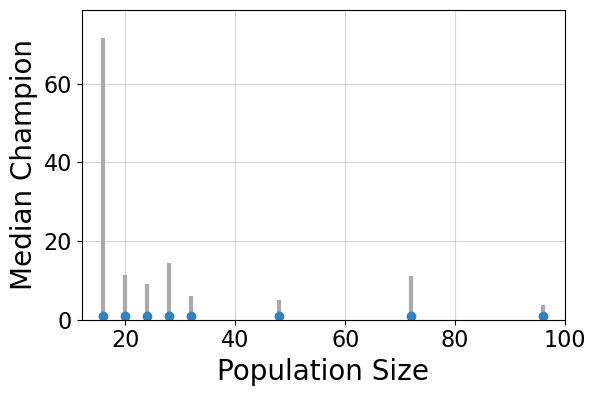

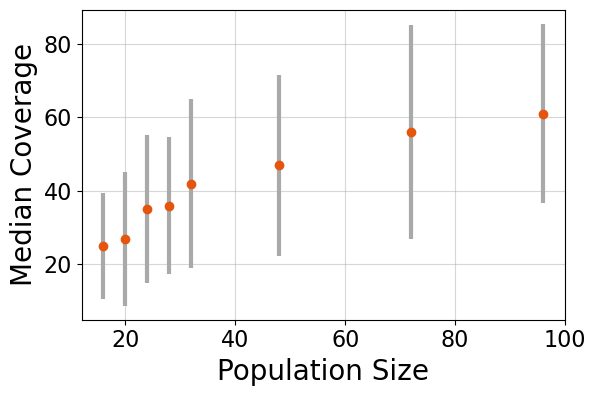

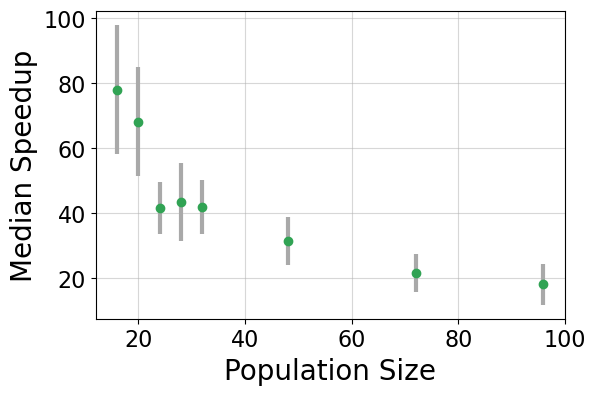

In [17]:
def plot_pop_size(y, yerr, y_axis_label, save_fig_name):

    X = [16, 20, 24, 28, 32, 48, 72, 96]

    fig, ax1 = plt.subplots(dpi=100)

    if y_axis_label == 'Median Champion':
        ax1.errorbar(X, y, yerr=yerr, fmt='o', color='#3182bd',
             ecolor='darkgrey', elinewidth=3, capsize=0)
        ax1.set(ylim=0)
    elif y_axis_label == 'Median Coverage':
        ax1.errorbar(X, y, yerr=yerr, fmt='o', color='#e6550d',
             ecolor='darkgrey', elinewidth=3, capsize=0)
    else:
        ax1.errorbar(X, y, yerr=yerr, fmt='o', color='#31a354',
             ecolor='darkgrey', elinewidth=3, capsize=0)

    ax1.set_ylabel(y_axis_label, fontsize=20)

    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    
    ax1.set_xlabel('Population Size', fontsize=20)
    ax1.grid(alpha=0.5)
    ax1.set_axisbelow(True)

    plt.tight_layout()

    plt.savefig(save_fig_name + '_median.pdf', dpi=600)
    plt.savefig(save_fig_name + '_median.png', dpi=600)

df_16 = pd.read_csv('all_runs_performance/pop_size_performance_16.csv')
df_20 = pd.read_csv('all_runs_performance/pop_size_performance_20.csv')
df_24 = pd.read_csv('all_runs_performance/pop_size_performance_24.csv')
df_28 = pd.read_csv('all_runs_performance/pop_size_performance_28.csv')
df_32 = pd.read_csv('all_runs_performance/pop_size_performance_32.csv')
df_48 = pd.read_csv('all_runs_performance/pop_size_performance_48.csv')
df_72 = pd.read_csv('all_runs_performance/pop_size_performance_72.csv')
df_96 = pd.read_csv('all_runs_performance/pop_size_performance_96.csv')


med_champions = [size_16_champion_med, size_20_champion_med, size_28_champion_med, size_28_champion_med, size_32_champion_med, size_48_champion_med, size_72_champion_med, size_96_champion_med]
champion_std = [np.std(df_16['Champion']), np.std(df_20['Champion']), np.std(df_24['Champion']), np.std(df_28['Champion']),  np.std(df_32['Champion']), np.std(df_48['Champion']), np.std(df_72['Champion']), np.std(df_96['Champion'])]
plot_pop_size(med_champions, champion_std, 'Median Champion', 'pop_size_mean_champion')

med_coverage = [size_16_coverage_med, size_20_coverage_med, size_24_coverage_med, size_28_coverage_med, size_32_coverage_med, size_48_coverage_med, size_72_coverage_med, size_96_coverage_med]
coverage_std = [np.std(df_16['Coverage']), np.std(df_20['Coverage']), np.std(df_24['Coverage']), np.std(df_28['Coverage']),  np.std(df_32['Coverage']), np.std(df_48['Coverage']), np.std(df_72['Coverage']), np.std(df_96['Coverage'])]
plot_pop_size(med_coverage, coverage_std, 'Median Coverage', 'pop_size_mean_coverage')

med_speedup = [size_16_speedup_med, size_20_speedup_med, size_24_speedup_med, size_28_speedup_med, size_32_speedup_med, size_48_speedup_med, size_72_speedup_med, size_96_speedup_med]
speedup_std = [np.std(df_16['Speedup']), np.std(df_20['Speedup']), np.std(df_24['Speedup']), np.std(df_28['Speedup']),  np.std(df_32['Speedup']), np.std(df_48['Speedup']), np.std(df_72['Speedup']), np.std(df_96['Speedup'])]
plot_pop_size(med_speedup, speedup_std, 'Median Speedup', 'pop_size_mean_speedup')

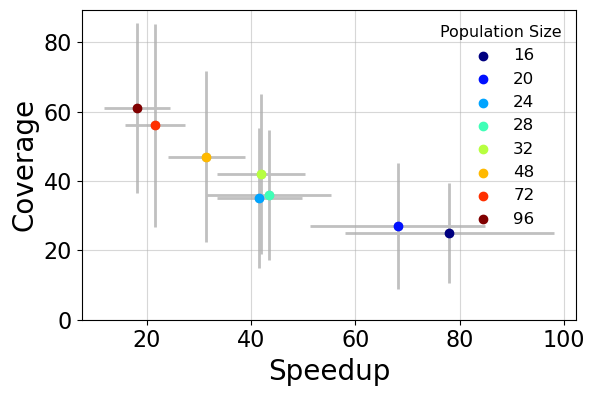

In [18]:

labels = ['16', '20', '24', '28', '32', '48', '72', '96']
plot_coverage_vs_speedup(med_speedup , med_coverage, speedup_std, coverage_std, 'pop_size', 'Population Size', labels)

# Selection Methods

In [26]:


def selection_method_find_average_performance(param, positive_props = False):
    positive_props_list = ['polar', 'opt_bg']
    full_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    
    selection_method_champions = []
    selection_method_coverage = []
    selection_method_speedup = []

    index_prop = []
    labels = []

    if positive_props == True:
        props_list = positive_props_list
    else:
        props_list = chem_properties
    for prop in props_list:
        if prop == 'polar':
            ranked_file = polar_ranked_file
        elif prop == 'opt_bg':
            ranked_file = opt_bg_ranked_file
        else:
            ranked_file = solv_eng_ranked_file

        if positive_props == False:
            for x in run_labels:
                full_analysis_file = '../full_files/full_analysis_selection_method_%s_%s_%s.csv' % (param, prop, x)
                champion, coverage, speedup = get_performance_metrics(ranked_file, full_analysis_file)
                selection_method_champions.append(champion)
                selection_method_coverage.append(coverage)
                selection_method_speedup.append(speedup)
                index_prop.append(prop)
                labels.append(x)
        else:
            for x in full_labels:
                full_analysis_file = '../full_files/full_analysis_selection_method_%s_%s_%s.csv' % (param, prop, x)
                champion, coverage, speedup = get_performance_metrics(ranked_file, full_analysis_file)
                selection_method_champions.append(champion)
                selection_method_coverage.append(coverage)
                selection_method_speedup.append(speedup)
                index_prop.append(prop)
                labels.append(x)

    selection_method_champions_med = statistics.median(selection_method_champions)
    selection_method_coverage_med = statistics.median(selection_method_coverage)
    selection_method_speedup_med = statistics.median(selection_method_speedup)

    if positive_props == False:
        if len(selection_method_champions) != 15:
            return 'missing a run'

    zipped = zip(labels, selection_method_champions, selection_method_coverage, selection_method_speedup)
    df_selection_methods = pd.DataFrame(zipped, index = index_prop, columns = ['Run Label', 'Champion', 'Coverage', 'Speedup'])

    if positive_props == False:
        df_selection_methods.to_csv('all_runs_performance/selection_methods_performance_%s.csv' % (param))
    else:
        df_selection_methods.to_csv('all_runs_performance/selection_methods_performance__polar_optbg_%s.csv' % (param))
        
    return selection_method_champions_med, selection_method_coverage_med, selection_method_speedup_med

In [27]:
tournament_2_champion_med, tournament_2_coverage_med, tournament_2_speedup_med = selection_method_find_average_performance('tournament_2')
tournament_3_champion_med, tournament_3_coverage_med, tournament_3_speedup_med = selection_method_find_average_performance('tournament_3')
tournament_4_champion_med, tournament_4_coverage_med, tournament_4_speedup_med = selection_method_find_average_performance('tournament_4')
random_champion_med, random_coverage_med, random_speedup_med = selection_method_find_average_performance('random')
random_top50_champion_med, random_top50_coverage_med, random_top50_speedup_med = selection_method_find_average_performance('random_top50')
roulette_champion_med, roulette_coverage_med, roulette_speedup_med = selection_method_find_average_performance('roulette')
roulette_2props_champion_med, roulette_2props_coverage_med, roulette_2props_speedup_med = selection_method_find_average_performance('roulette', positive_props=True)
rank_champion_med, rank_coverage_med, rank_speedup_med = selection_method_find_average_performance('rank')
SUS_champion_med, SUS_coverage_med, SUS_speedup_med = selection_method_find_average_performance('SUS')
SUS_2props_champion_med, SUS_2props_coverage_med, SUS_2props_speedup_med = selection_method_find_average_performance('SUS', positive_props=True)


print('tournament 2 way')
print(tournament_2_champion_med, tournament_2_coverage_med, tournament_2_speedup_med)

print('tournament 3 way')
print(tournament_3_champion_med, tournament_3_coverage_med, tournament_3_speedup_med)

print('tournament 4 way')
print(tournament_4_champion_med, tournament_4_coverage_med, tournament_4_speedup_med)

print('random')
print(random_champion_med, random_coverage_med, random_speedup_med)

print('random top 50%')
print(random_top50_champion_med, random_top50_coverage_med, random_top50_speedup_med)

print('roulette')
print(roulette_champion_med, roulette_coverage_med, roulette_speedup_med)

print('roulette for polar + opt_bg')
print(roulette_2props_champion_med, roulette_2props_coverage_med, roulette_2props_speedup_med)

print('rank')
print(rank_champion_med, rank_coverage_med, rank_speedup_med)

print('SUS')
print(SUS_champion_med, SUS_coverage_med, SUS_speedup_med)

print('SUS for polar + opt_bg')
print(SUS_2props_champion_med, SUS_2props_coverage_med, SUS_2props_speedup_med)

tournament 2 way
1.0 39 44.521120497999114
tournament 3 way
1.0 43 54.71475409836066
tournament 4 way
1.0 50 49.29985228951256
random
1.0 42 41.91209711176224
random top 50%
1.0 35 47.45402843601896
roulette
4.0 29 46.44155844155844
roulette for polar + opt_bg
1.0 44.5 46.920594976076714
rank
1.0 44 42.30164765525982
SUS
4.0 7 52.15
SUS for polar + opt_bg
1.0 42.5 47.51901032799909


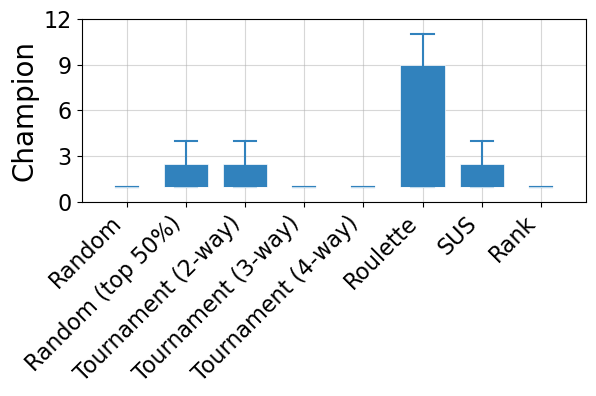

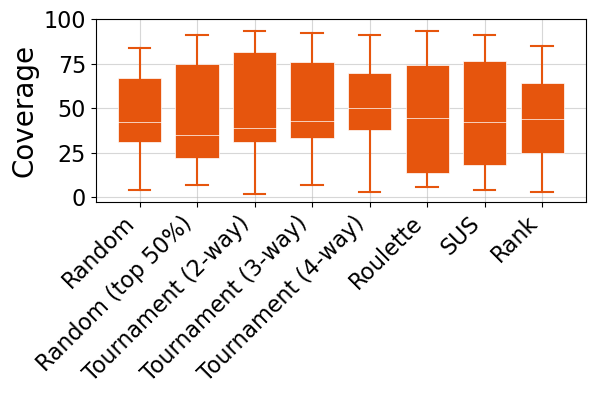

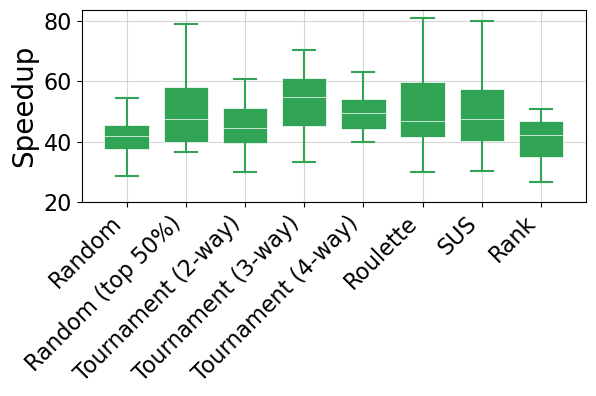

In [28]:
def plot_selection_methods(y, y_axis_label, save_fig_name):

    X = ['Random', 'Random (top 50%)', 'Tournament (2-way)', 'Tournament (3-way)','Tournament (4-way)', 'Roulette', 'SUS', 'Rank']

    fig, ax1 = plt.subplots(dpi=100)

    if y_axis_label == 'Champion':

        ax1.boxplot(y, positions=[2, 4, 6, 8, 10, 12, 14, 16],labels = X, widths=1.5, patch_artist=True,
            showmeans=False, showfliers=False, 
            medianprops={"color": "white", "linewidth": 0.5},
            boxprops={"facecolor": "#3182bd", "edgecolor": "white", "linewidth": 0.5},
            whiskerprops={"color": "#3182bd", "linewidth": 1.5},
            capprops={"color": "#3182bd", "linewidth": 1.5})

        ax1.set_yticks([0, 3, 6, 9, 12])

    elif y_axis_label == 'Coverage':
        ax1.boxplot(y, positions=[2, 4, 6, 8, 10, 12, 14, 16], labels = X, widths=1.5, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 0.5},
            boxprops={"facecolor": "#e6550d", "edgecolor": "white", "linewidth": 0.5},
            whiskerprops={"color": "#e6550d", "linewidth": 1.5},
            capprops={"color": "#e6550d", "linewidth": 1.5})

        ax1.set_yticks([0, 25, 50, 75, 100])

    else:
        ax1.boxplot(y, positions=[2, 4, 6, 8, 10, 12, 14, 16], labels = X, widths=1.5, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 0.5},
            boxprops={"facecolor": "#31a354", "edgecolor": "white", "linewidth": 0.5},
            whiskerprops={"color": "#31a354", "linewidth": 1.5},
            capprops={"color": "#31a354", "linewidth": 1.5})

        ax1.set_yticks([20, 40, 60, 80])


    ax1.set_ylabel(y_axis_label, fontsize=20)

    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)


    ax1.set_xticklabels(X, rotation = 45, ha='right')


    #ax1.set(xlim=(0, 100))

    #ax1.set_xlabel('Population Size', fontsize=20)
    ax1.grid(alpha=0.5)
    ax1.set_axisbelow(True)


    plt.tight_layout()

    plt.savefig(save_fig_name + '.pdf', dpi=600)
    plt.savefig(save_fig_name + '.png', dpi=600)

SUS_df = pd.read_csv('all_runs_performance/selection_methods_performance_polar_optbg_SUS.csv')
rank_df = pd.read_csv('all_runs_performance/selection_methods_performance_rank.csv')
roulette_df = pd.read_csv('all_runs_performance/selection_methods_performance_polar_optbg_roulette.csv')
random_top50_df = pd.read_csv('all_runs_performance/selection_methods_performance_random_top50.csv')
random_df = pd.read_csv('all_runs_performance/selection_methods_performance_random.csv')
tournament_2_df = pd.read_csv('all_runs_performance/selection_methods_performance_tournament_2.csv')
tournament_3_df = pd.read_csv('all_runs_performance/selection_methods_performance_tournament_3.csv')
tournament_4_df = pd.read_csv('all_runs_performance/selection_methods_performance_tournament_4.csv')

champions_std = [ np.std(random_df['Champion']), np.std(random_top50_df['Champion']), np.std(tournament_2_df['Champion']), np.std(tournament_3_df['Champion']),np.std(tournament_4_df['Champion']),  np.std(roulette_df['Champion']), np.std(SUS_df['Champion']), np.std(rank_df['Champion'])]
champions = [ list(random_df['Champion']), list(random_top50_df['Champion']), list(tournament_2_df['Champion']), list(tournament_3_df['Champion']),list(tournament_4_df['Champion']),  list(roulette_df['Champion']), list(SUS_df['Champion']), list(rank_df['Champion'])]
champions_med = [random_champion_med, random_top50_champion_med, tournament_2_champion_med, tournament_3_champion_med, tournament_4_champion_med, roulette_2props_champion_med, SUS_2props_champion_med, rank_champion_med]
plot_selection_methods(champions, 'Champion', 'selection_methods_champion')

coverage_std = [ np.std(random_df['Coverage']), np.std(random_top50_df['Coverage']), np.std(tournament_2_df['Coverage']), np.std(tournament_3_df['Coverage']), np.std(tournament_4_df['Coverage']), np.std(roulette_df['Coverage']), np.std(SUS_df['Coverage']), np.std(rank_df['Coverage'])]
coverage_med = [random_coverage_med, random_top50_coverage_med, tournament_2_coverage_med, tournament_3_coverage_med, tournament_4_coverage_med, roulette_2props_coverage_med, SUS_2props_coverage_med, rank_coverage_med]
coverage = [ list(random_df['Coverage']), list(random_top50_df['Coverage']), list(tournament_2_df['Coverage']), list(tournament_3_df['Coverage']), list(tournament_4_df['Coverage']), list(roulette_df['Coverage']), list(SUS_df['Coverage']), list(rank_df['Coverage'])]
plot_selection_methods(coverage, 'Coverage', 'selection_methods_coverage')

speedup_std = [ np.std(random_df['Speedup']), np.std(random_top50_df['Speedup']), np.std(tournament_2_df['Speedup']), np.std(tournament_3_df['Speedup']),  np.std(tournament_4_df['Speedup']), np.std(roulette_df['Speedup']), np.std(SUS_df['Speedup']), np.std(rank_df['Speedup'])]
speedup_med = [random_speedup_med, random_top50_speedup_med, tournament_2_speedup_med, tournament_3_speedup_med, tournament_4_speedup_med, roulette_2props_speedup_med, SUS_2props_speedup_med, rank_speedup_med]
speedup = [ list(random_df['Speedup']), list(random_top50_df['Speedup']), list(tournament_2_df['Speedup']), list(tournament_3_df['Speedup']),  list(tournament_4_df['Speedup']), list(roulette_df['Speedup']), list(SUS_df['Speedup']), list(rank_df['Speedup'])]
plot_selection_methods(speedup, 'Speedup', 'selection_methods_speedup')

#plot_selection_methods_onefig([champions, coverage, speedup])

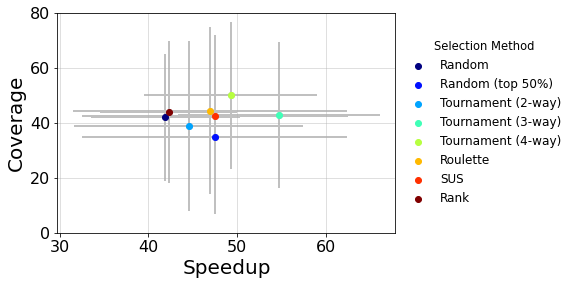

In [44]:
labels = ['Random', 'Random (top 50%)', 'Tournament (2-way)', 'Tournament (3-way)','Tournament (4-way)', 'Roulette', 'SUS', 'Rank']
plot_coverage_vs_speedup(speedup_med , coverage_med, speedup_std, coverage_std, 'selection_method', 'Selection Method', labels, legend_outside=True)

### ANOVA

### Champion

In [56]:
df_champion = pd.DataFrame(champions)
df_champion = df_champion.transpose()
df_champion.columns =['Random', 'Random (top 50%)', 'Tournament (2-way)', 'Tournament (3-way)','Tournament (4-way)', 'Roulette', 'SUS', 'Rank']

df_champion_melt = pd.melt(df_champion.reset_index(), id_vars=['index'], value_vars=['Random', 'Random (top 50%)', 'Tournament (2-way)', 'Tournament (3-way)','Tournament (4-way)', 'Roulette', 'SUS', 'Rank'])
df_champion_melt.columns = ['index', 'group', 'value']

# generate model for linear regression
my_model = smf.ols(formula='value ~ group', data=df_champion_melt)
# fit model 
my_model_fit = my_model.fit()

print(my_model_fit.summary())

anova_table = sm.stats.anova_lm(my_model_fit, typ=2)
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.6118
Date:                Wed, 15 Jun 2022   Prob (F-statistic):              0.745
Time:                        14:02:25   Log-Likelihood:                -516.18
No. Observations:                 130   AIC:                             1048.
Df Residuals:                     122   BIC:                             1071.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

p is greater than 0.05 so there is no statistical difference between the methods

### Coverage

In [57]:
df_coverage = pd.DataFrame(coverage)
df_coverage = df_coverage.transpose()
df_coverage.columns =['Random', 'Random (top 50%)', 'Tournament (2-way)', 'Tournament (3-way)','Tournament (4-way)', 'Roulette', 'SUS', 'Rank']

df_coverage_melt = pd.melt(df_coverage.reset_index(), id_vars=['index'], value_vars=['Random', 'Random (top 50%)', 'Tournament (2-way)', 'Tournament (3-way)','Tournament (4-way)', 'Roulette', 'SUS', 'Rank'])
df_coverage_melt.columns = ['index', 'group', 'value']

# generate model for linear regression
my_model = smf.ols(formula='value ~ group', data=df_coverage_melt)
# fit model 
my_model_fit = my_model.fit()

print(my_model_fit.summary())

anova_table = sm.stats.anova_lm(my_model_fit, typ=2)
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.050
Method:                 Least Squares   F-statistic:                    0.1252
Date:                Wed, 15 Jun 2022   Prob (F-statistic):              0.996
Time:                        14:08:20   Log-Likelihood:                -617.29
No. Observations:                 130   AIC:                             1251.
Df Residuals:                     122   BIC:                             1274.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

There is no statistical difference among coverage

### Speedup

In [58]:
df_speedup = pd.DataFrame(speedup)
df_speedup = df_speedup.transpose()
df_speedup.columns =['Random', 'Random (top 50%)', 'Tournament (2-way)', 'Tournament (3-way)','Tournament (4-way)', 'Roulette', 'SUS', 'Rank']

df_speedup_melt = pd.melt(df_speedup.reset_index(), id_vars=['index'], value_vars=['Random', 'Random (top 50%)', 'Tournament (2-way)', 'Tournament (3-way)','Tournament (4-way)', 'Roulette', 'SUS', 'Rank'])
df_speedup_melt.columns = ['index', 'group', 'value']

# generate model for linear regression
my_model = smf.ols(formula='value ~ group', data=df_speedup_melt)
# fit model 
my_model_fit = my_model.fit()

print(my_model_fit.summary())

anova_table = sm.stats.anova_lm(my_model_fit, typ=2)
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     2.073
Date:                Wed, 15 Jun 2022   Prob (F-statistic):             0.0514
Time:                        14:09:31   Log-Likelihood:                -513.32
No. Observations:                 130   AIC:                             1043.
Df Residuals:                     122   BIC:                             1066.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

There is no statistical difference

# Mutation Rate

In [74]:
def mut_rate_find_average_performance(param):

    mut_rate_champions = []
    mut_rate_coverage = []
    mut_rate_speedup = []
    labels = []
    index_prop = []

    for prop in chem_properties:
        if prop == 'polar':
            ranked_file = polar_ranked_file
        elif prop == 'opt_bg':
            ranked_file = opt_bg_ranked_file
        else:
            ranked_file = solv_eng_ranked_file
        for x in run_labels:
            full_analysis_file = '../full_files/full_analysis_mutation_rate_%s_%s_%s.csv' % (param, prop, x)
            champion, coverage, speedup = get_performance_metrics(ranked_file, full_analysis_file)
            mut_rate_champions.append(champion)
            mut_rate_coverage.append(coverage)
            mut_rate_speedup.append(speedup)
            labels.append(x)
            index_prop.append(prop)

    mut_rate_champions_med = statistics.median(mut_rate_champions)
    mut_rate_coverage_med = statistics.median(mut_rate_coverage)
    mut_rate_speedup_med = statistics.median(mut_rate_speedup)

    zipped = zip(labels, mut_rate_champions, mut_rate_coverage, mut_rate_speedup)
    df_mut_rate = pd.DataFrame(zipped, index = index_prop, columns = ['Run Label', 'Champion', 'Coverage', 'Speedup'])
    df_mut_rate.to_csv('all_runs_performance/mut_rate_performance_%s.csv' % (param))


    if len(mut_rate_champions) != 15:
        return 'missing a run'

    return mut_rate_champions_med, mut_rate_coverage_med, mut_rate_speedup_med

In [75]:
one_champion_med, one_coverage_med, one_speedup_med = mut_rate_find_average_performance('1')
five_champion_med, five_coverage_med, five_speedup_med = mut_rate_find_average_performance('5')
ten_champion_med, ten_coverage_med, ten_speedup_med = mut_rate_find_average_performance('10')
twenty_champion_med, twenty_coverage_med, twenty_speedup_med = mut_rate_find_average_performance('20')
thirty_champion_med, thirty_coverage_med, thirty_speedup_med = mut_rate_find_average_performance('30')
forty_champion_med, forty_coverage_med, forty_speedup_med = mut_rate_find_average_performance('40')
fifty_champion_med, fifty_coverage_med, fifty_speedup_med = mut_rate_find_average_performance('50')
sixty_champion_med, sixty_coverage_med, sixty_speedup_med = mut_rate_find_average_performance('60')
seventy_champion_med, seventy_coverage_med, seventy_speedup_med = mut_rate_find_average_performance('70')
eighty_champion_med, eighty_coverage_med, eighty_speedup_med = mut_rate_find_average_performance('80')
ninety_champion_med, ninety_coverage_med, ninety_speedup_med = mut_rate_find_average_performance('90')

print('1%')
print(one_champion_med, one_coverage_med, one_speedup_med)

print('5%')
print(five_champion_med, five_coverage_med, five_speedup_med)

print('10%')
print(ten_champion_med, ten_coverage_med, ten_speedup_med)

print('20%')
print(twenty_champion_med, twenty_coverage_med, twenty_speedup_med)

print('30%')
print(thirty_champion_med, thirty_coverage_med, thirty_speedup_med)

print('40%')
print(forty_champion_med, forty_coverage_med, forty_speedup_med)

print('50%')
print(fifty_champion_med, fifty_coverage_med, fifty_speedup_med)

print('60%')
print(sixty_champion_med, sixty_coverage_med, sixty_speedup_med)

print('70%')
print(seventy_champion_med, seventy_coverage_med, seventy_speedup_med)

print('80%')
print(eighty_champion_med, eighty_coverage_med, eighty_speedup_med)

print('90%')
print(ninety_champion_med, ninety_coverage_med, ninety_speedup_med)

1%
14.0 3 169.42131979695432
5%
4.0 14 69.53333333333333
10%
1.0 22 52.45049764274489
20%
1.0 31 41.96479463537301
30%
1.0 41 37.61382419233659
40%
1.0 42 41.91209711176224
50%
1.0 40 36.56975894813733
60%
1.0 34 36.09516943042538
70%
1.0 42 31.716186252771617
80%
1.0 42 34.43191196698762
90%
1.0 42 30.08653846153846


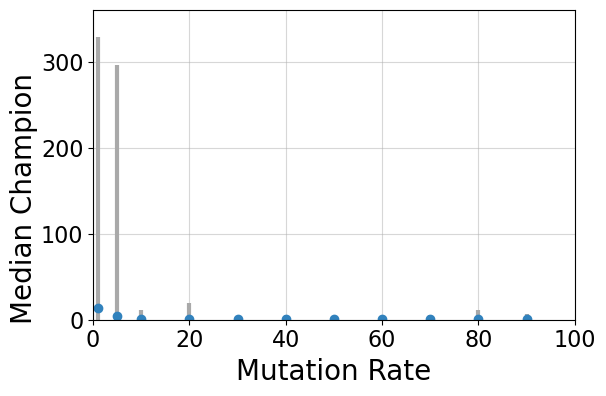

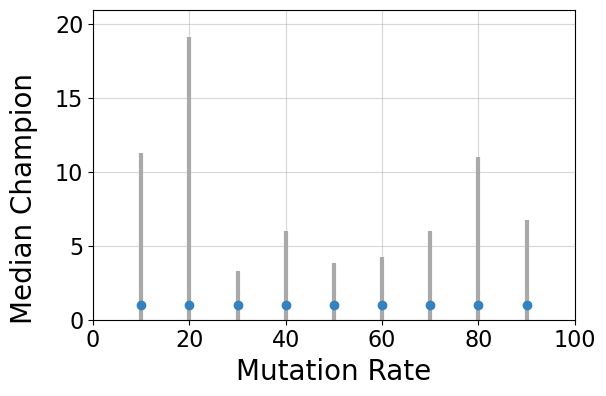

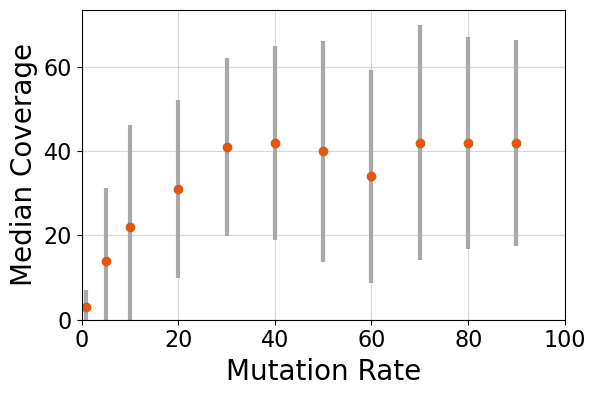

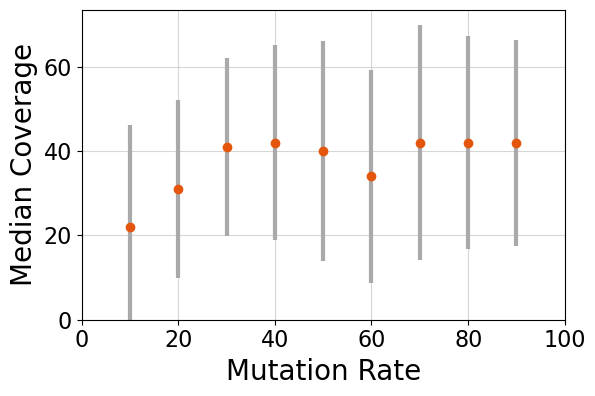

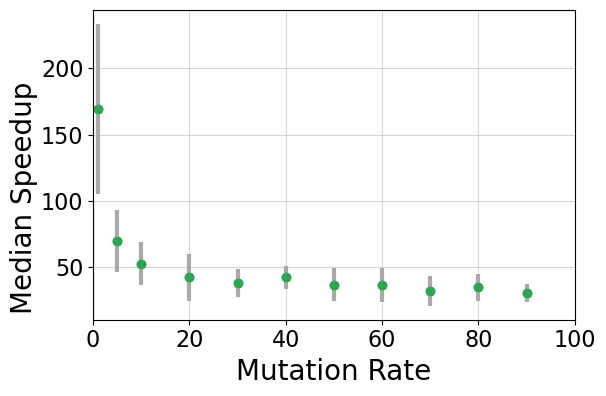

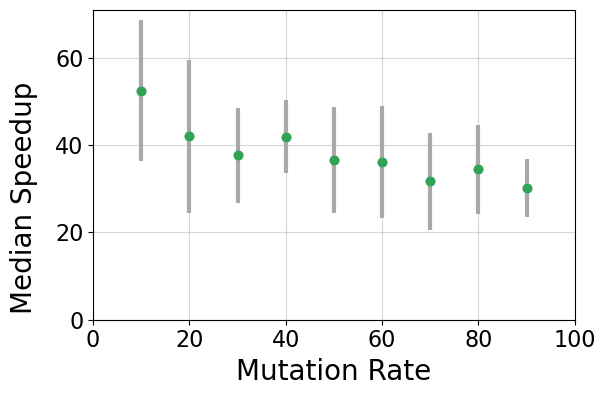

In [175]:
def plot_mut_rate_full(y, yerr, y_axis_label, save_fig_name):

    X = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90]

    if y_axis_label == 'Median Champion':
        fig, ax2 = plt.subplots(dpi=100)
        fig.subplots_adjust(hspace=0.1)

        ax2.errorbar(X, y, yerr=yerr, fmt='o', color='#3182bd',
             ecolor='darkgrey', elinewidth=3, capsize=0)

        #ax2.set_ylim(0, 25)
        ax2.set(xlim=(0, 100))
        ax2.set(ylim=0)

        plt.ylabel(y_axis_label, fontsize=20)
        ax2.yaxis.set_label_coords(0.05, 0.5, transform=fig.transFigure)

        ax2.tick_params(axis='x', labelsize=16, labeltop=False)
        ax2.tick_params(axis='y', labelsize=16)

        ax2.set_xlabel('Mutation Rate', fontsize=20)
        ax2.grid(alpha=0.5)
        ax2.set_axisbelow(True)

    elif y_axis_label == 'Median Coverage':
        fig, ax1 = plt.subplots(dpi=100)
        ax1.errorbar(X, y, yerr=yerr, fmt='o', color='#e6550d',
             ecolor='darkgrey', elinewidth=3, capsize=0)

        ax1.set_ylabel(y_axis_label, fontsize=20)

        ax1.tick_params(axis='x', labelsize=16, labeltop=False)
        ax1.tick_params(axis='y', labelsize=16)

        ax1.set(xlim=(0, 100))
        ax1.set(ylim=0)

        ax1.set_xlabel('Mutation Rate', fontsize=20)
        ax1.grid(alpha=0.5)
        ax1.set_axisbelow(True)
    else:
        fig, ax2 = plt.subplots(dpi=100)
        fig.subplots_adjust(hspace=0.1)
        ax2.scatter(X,  y, color='#31a354')

        ax2.errorbar(X, y, yerr=yerr, fmt='o', color='#31a354',
             ecolor='darkgrey', elinewidth=3, capsize=0)

        #ax2.set_ylim(20, 80) #other data range
        ax2.set(xlim=(0, 100))

        plt.ylabel(y_axis_label, fontsize=20)
        ax2.yaxis.set_label_coords(0.05, 0.5, transform=fig.transFigure)

        ax2.tick_params(axis='x', labelsize=16, labeltop=False)
        ax2.tick_params(axis='y', labelsize=16)

        ax2.set_xlabel('Mutation Rate', fontsize=20)
        ax2.grid(alpha=0.5)
        ax2.set_axisbelow(True)

    plt.tight_layout()

    plt.savefig(save_fig_name + '_median.pdf', dpi=600)
    plt.savefig(save_fig_name + '_median.png', dpi=600)

def plot_mut_rate_zoomed(y, yerr, y_axis_label, save_fig_name):

    X = [10, 20, 30, 40, 50, 60, 70, 80, 90]

    if y_axis_label == 'Median Champion':
        fig, ax2 = plt.subplots(dpi=100)
        fig.subplots_adjust(hspace=0.1)

        ax2.errorbar(X, y, yerr=yerr, fmt='o', color='#3182bd',
             ecolor='darkgrey', elinewidth=3, capsize=0)

        #ax2.set_ylim(0, 25)
        ax2.set(xlim=(0, 100))
        ax2.set_ylim(0)

        plt.ylabel(y_axis_label, fontsize=20)
        ax2.yaxis.set_label_coords(0.05, 0.5, transform=fig.transFigure)

        ax2.tick_params(axis='x', labelsize=16, labeltop=False)
        ax2.tick_params(axis='y', labelsize=16)

        ax2.set_xlabel('Mutation Rate', fontsize=20)
        ax2.grid(alpha=0.5)
        ax2.set_axisbelow(True)

    elif y_axis_label == 'Median Coverage':
        fig, ax1 = plt.subplots(dpi=100)
        ax1.errorbar(X, y, yerr=yerr, fmt='o', color='#e6550d',
             ecolor='darkgrey', elinewidth=3, capsize=0)

        ax1.set_ylabel(y_axis_label, fontsize=20)

        ax1.tick_params(axis='x', labelsize=16, labeltop=False)
        ax1.tick_params(axis='y', labelsize=16)

        ax1.set(xlim=(0, 100))
        ax1.set(ylim=0)

        ax1.set_xlabel('Mutation Rate', fontsize=20)
        ax1.grid(alpha=0.5)
        ax1.set_axisbelow(True)
    else:
        fig, ax2 = plt.subplots(dpi=100)
        fig.subplots_adjust(hspace=0.1)
        ax2.scatter(X,  y, color='#31a354')

        ax2.errorbar(X, y, yerr=yerr, fmt='o', color='#31a354',
             ecolor='darkgrey', elinewidth=3, capsize=0)

        ax2.set_ylim(0) #other data range
        ax2.set(xlim=(0, 100))

        plt.ylabel(y_axis_label, fontsize=20)
        ax2.yaxis.set_label_coords(0.05, 0.5, transform=fig.transFigure)

        ax2.tick_params(axis='x', labelsize=16, labeltop=False)
        ax2.tick_params(axis='y', labelsize=16)

        ax2.set_xlabel('Mutation Rate', fontsize=20)
        ax2.grid(alpha=0.5)
        ax2.set_axisbelow(True)

    plt.tight_layout()

    plt.savefig(save_fig_name + '_median_zoomed.pdf', dpi=600)
    plt.savefig(save_fig_name + '_median_zoomed.png', dpi=600)

mut_rate_1_df = pd.read_csv('all_runs_performance/mut_rate_performance_1.csv')
mut_rate_5_df = pd.read_csv('all_runs_performance/mut_rate_performance_5.csv')
mut_rate_10_df = pd.read_csv('all_runs_performance/mut_rate_performance_10.csv')
mut_rate_20_df = pd.read_csv('all_runs_performance/mut_rate_performance_20.csv')
mut_rate_30_df = pd.read_csv('all_runs_performance/mut_rate_performance_30.csv')
mut_rate_40_df = pd.read_csv('all_runs_performance/mut_rate_performance_40.csv')
mut_rate_50_df = pd.read_csv('all_runs_performance/mut_rate_performance_50.csv')
mut_rate_60_df = pd.read_csv('all_runs_performance/mut_rate_performance_60.csv')
mut_rate_70_df = pd.read_csv('all_runs_performance/mut_rate_performance_70.csv')
mut_rate_80_df = pd.read_csv('all_runs_performance/mut_rate_performance_80.csv')
mut_rate_90_df = pd.read_csv('all_runs_performance/mut_rate_performance_90.csv')


med_champions = [one_champion_med, five_champion_med, ten_champion_med, twenty_champion_med, thirty_champion_med, forty_champion_med, fifty_champion_med, sixty_champion_med, seventy_champion_med, eighty_champion_med, ninety_champion_med]
champion_std = [np.std(mut_rate_1_df['Champion']), np.std(mut_rate_5_df['Champion']), np.std(mut_rate_10_df['Champion']), np.std(mut_rate_20_df['Champion']),  np.std(mut_rate_30_df['Champion']), np.std(mut_rate_40_df['Champion']), np.std(mut_rate_50_df['Champion']), np.std(mut_rate_60_df['Champion']), np.std(mut_rate_70_df['Champion']), np.std(mut_rate_80_df['Champion']), np.std(mut_rate_90_df['Champion'])]
plot_mut_rate_full(med_champions, champion_std, 'Median Champion', 'mut_rate_med_champion')
plot_mut_rate_zoomed(med_champions[2:], champion_std[2:], 'Median Champion', 'mut_rate_med_champion')

med_coverage = [one_coverage_med,five_coverage_med,  ten_coverage_med, twenty_coverage_med, thirty_coverage_med, forty_coverage_med, fifty_coverage_med, sixty_coverage_med, seventy_coverage_med, eighty_coverage_med, ninety_coverage_med]
coverage_std = [np.std(mut_rate_1_df['Coverage']), np.std(mut_rate_5_df['Coverage']), np.std(mut_rate_10_df['Coverage']), np.std(mut_rate_20_df['Coverage']),  np.std(mut_rate_30_df['Coverage']), np.std(mut_rate_40_df['Coverage']), np.std(mut_rate_50_df['Coverage']), np.std(mut_rate_60_df['Coverage']), np.std(mut_rate_70_df['Coverage']), np.std(mut_rate_80_df['Coverage']), np.std(mut_rate_90_df['Coverage'])]
plot_mut_rate_full(med_coverage, coverage_std, 'Median Coverage', 'mut_rate_med_coverage')
plot_mut_rate_zoomed(med_coverage[2:], coverage_std[2:], 'Median Coverage', 'mut_rate_med_coverage')

med_speedup = [one_speedup_med, five_speedup_med, ten_speedup_med, twenty_speedup_med, thirty_speedup_med, forty_speedup_med, fifty_speedup_med, sixty_speedup_med, seventy_speedup_med, eighty_speedup_med, ninety_speedup_med]
speedup_std = [np.std(mut_rate_1_df['Speedup']), np.std(mut_rate_5_df['Speedup']), np.std(mut_rate_10_df['Speedup']), np.std(mut_rate_20_df['Speedup']),  np.std(mut_rate_30_df['Speedup']), np.std(mut_rate_40_df['Speedup']), np.std(mut_rate_50_df['Speedup']), np.std(mut_rate_60_df['Speedup']), np.std(mut_rate_70_df['Speedup']), np.std(mut_rate_80_df['Speedup']), np.std(mut_rate_90_df['Speedup'])]
plot_mut_rate_full(med_speedup, speedup_std, 'Median Speedup', 'mut_rate_med_speedup')
plot_mut_rate_zoomed(med_speedup[2:], speedup_std[2:], 'Median Speedup', 'mut_rate_med_speedup')

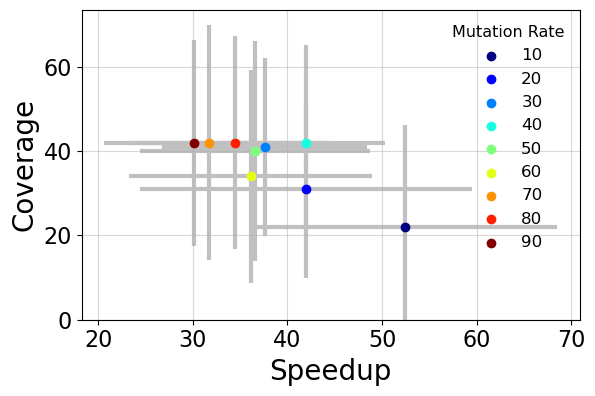

In [176]:
labels = ['10', '20', '30', '40', '50', '60', '70', '80', '90']
plot_coverage_vs_speedup(med_speedup[2:] , med_coverage[2:], speedup_std[2:], coverage_std[2:], 'mut_rate', 'Mutation Rate', labels)

# Elitism

In [6]:
def elite_find_average_performance(param):

    elite_rate_champions = []
    elite_rate_coverage = []
    elite_rate_speedup = []
    labels = []
    index_prop = []

    for prop in chem_properties:
        if prop == 'polar':
            ranked_file = polar_ranked_file
        elif prop == 'opt_bg':
            ranked_file = opt_bg_ranked_file
        else:
            ranked_file = solv_eng_ranked_file
        for x in run_labels:
            full_analysis_file = '../full_files/full_analysis_elitism_perc_%s_%s_%s.csv' % (param, prop, x)
            champion, coverage, speedup = get_performance_metrics(ranked_file, full_analysis_file)
            elite_rate_champions.append(champion)
            elite_rate_coverage.append(coverage)
            elite_rate_speedup.append(speedup)
            labels.append(x)
            index_prop.append(prop)

    elite_rate_champions_med = statistics.median(elite_rate_champions)
    elite_rate_coverage_med = statistics.median(elite_rate_coverage)
    elite_rate_speedup_med = statistics.median(elite_rate_speedup)

    zipped = zip(labels, elite_rate_champions, elite_rate_coverage, elite_rate_speedup)
    df_elitism = pd.DataFrame(zipped, index = index_prop, columns = ['Run Label', 'Champion', 'Coverage', 'Speedup'])
    df_elitism.to_csv('all_runs_performance/elitism_performance_%s.csv' % (param))


    if len(elite_rate_champions) != 15:
        return 'missing a run'

    return elite_rate_champions_med, elite_rate_coverage_med, elite_rate_speedup_med

In [7]:
champion_med_0, coverage_med_0, speedup_med_0 = elite_find_average_performance('0')
champion_med_5, coverage_med_5, speedup_med_5 = elite_find_average_performance('5')
champion_med_10, coverage_med_10, speedup_med_10 = elite_find_average_performance('10')
champion_med_15, coverage_med_15, speedup_med_15 = elite_find_average_performance('15')
champion_med_20, coverage_med_20, speedup_med_20 = elite_find_average_performance('20')
champion_med_25, coverage_med_25, speedup_med_25 = elite_find_average_performance('25')
champion_med_30, coverage_med_30, speedup_med_30 = elite_find_average_performance('30')
champion_med_40, coverage_med_40, speedup_med_40 = elite_find_average_performance('40')
champion_med_50, coverage_med_50, speedup_med_50 = elite_find_average_performance('50')
champion_med_60, coverage_med_60, speedup_med_60 = elite_find_average_performance('60')
champion_med_70, coverage_med_70, speedup_med_70 = elite_find_average_performance('70')
champion_med_80, coverage_med_80, speedup_med_80 = elite_find_average_performance('80')



print('0%')
print(champion_med_0, coverage_med_0, speedup_med_0)

print('5%')
print(champion_med_5, coverage_med_5, speedup_med_5)

print('10%')
print(champion_med_10, coverage_med_10, speedup_med_10)

print('15%')
print(champion_med_15, coverage_med_15, speedup_med_15)

print('20%')
print(champion_med_20, coverage_med_20, speedup_med_20)

print('25%')
print(champion_med_25, coverage_med_25, speedup_med_25)

print('30%')
print(champion_med_30, coverage_med_30, speedup_med_30)

print('40%')
print(champion_med_40, coverage_med_40, speedup_med_40)

print('50%')
print(champion_med_50, coverage_med_50, speedup_med_50)

print('60%')
print(champion_med_60, coverage_med_60, speedup_med_60)

print('70%')
print(champion_med_70, coverage_med_70, speedup_med_70)

print('80%')
print(champion_med_80, coverage_med_80, speedup_med_80)


0%
3.0 21 4.403940886699507
5%
1.0 46 8.121339930245762
10%
1.0 42 18.817515504604398
15%
1.0 37 15.516503951650396
20%
1.0 44 22.04976877339793
25%
1.0 47 22.97567691601652
30%
1.0 43 26.71504802561366
40%
1.0 41 34.3492281303602
50%
1.0 42 41.91209711176224
60%
1.0 36 45.47138964577657
70%
1.0 28 66.39787798408489
80%
1.0 21 75.45440844009043


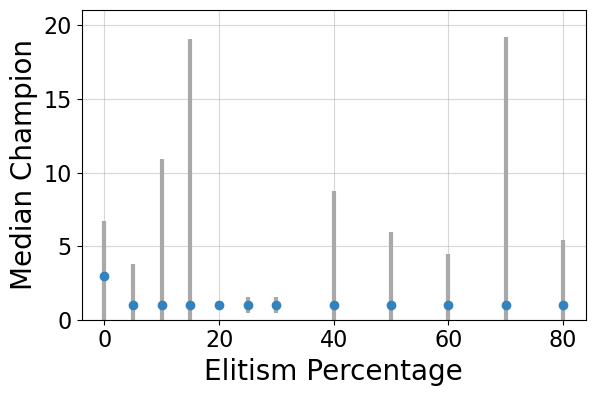

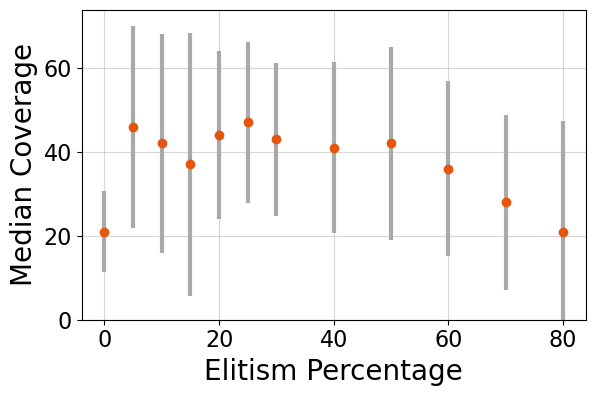

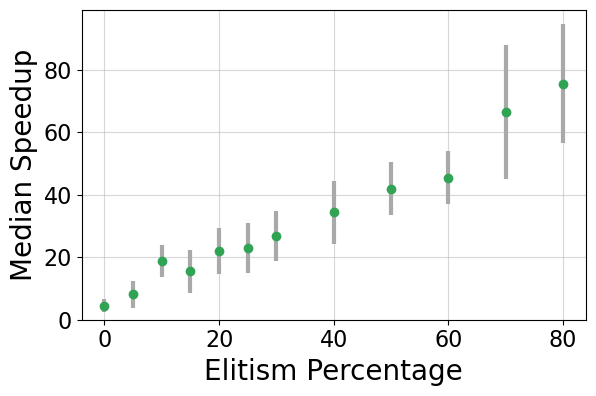

In [8]:
def plot_elitism(y, yerr, y_axis_label, save_fig_name):

    X = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80]

    fig, ax1 = plt.subplots(dpi=100)

    if y_axis_label == 'Median Champion':
        ax1.errorbar(X, y, yerr=yerr, fmt='o', color='#3182bd',
             ecolor='darkgrey', elinewidth=3, capsize=0)
    elif y_axis_label == 'Median Coverage':
        ax1.errorbar(X, y, yerr=yerr, fmt='o', color='#e6550d',
             ecolor='darkgrey', elinewidth=3, capsize=0)
    else:
        ax1.errorbar(X, y, yerr=yerr, fmt='o', color='#31a354',
             ecolor='darkgrey', elinewidth=3, capsize=0)

    ax1.set_ylabel(y_axis_label, fontsize=20)

    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)

    ax1.set(ylim=(0))

    ax1.set_xlabel('Elitism Percentage', fontsize=20)
    ax1.grid(alpha=0.5)
    ax1.set_axisbelow(True)

    plt.tight_layout()

    plt.savefig(save_fig_name + '_median.pdf', dpi=600)
    plt.savefig(save_fig_name + '_median.png', dpi=600)


elite_0_df = pd.read_csv('all_runs_performance/elitism_performance_0.csv')
elite_5_df = pd.read_csv('all_runs_performance/elitism_performance_5.csv')
elite_10_df = pd.read_csv('all_runs_performance/elitism_performance_10.csv')
elite_15_df = pd.read_csv('all_runs_performance/elitism_performance_15.csv')
elite_20_df = pd.read_csv('all_runs_performance/elitism_performance_20.csv')
elite_25_df = pd.read_csv('all_runs_performance/elitism_performance_25.csv')
elite_30_df = pd.read_csv('all_runs_performance/elitism_performance_30.csv')
elite_40_df = pd.read_csv('all_runs_performance/elitism_performance_40.csv')
elite_50_df = pd.read_csv('all_runs_performance/elitism_performance_50.csv')
elite_60_df = pd.read_csv('all_runs_performance/elitism_performance_60.csv')
elite_70_df = pd.read_csv('all_runs_performance/elitism_performance_70.csv')
elite_80_df = pd.read_csv('all_runs_performance/elitism_performance_80.csv')


med_champions = [champion_med_0,champion_med_5,  champion_med_10, champion_med_15, champion_med_20, champion_med_25, champion_med_30, champion_med_40, champion_med_50, champion_med_60, champion_med_70, champion_med_80]
champion_std = [np.std(elite_0_df['Champion']), np.std(elite_5_df['Champion']), np.std(elite_10_df['Champion']), np.std(elite_15_df['Champion']),  np.std(elite_20_df['Champion']), np.std(elite_25_df['Champion']), np.std(elite_30_df['Champion']), np.std(elite_40_df['Champion']), np.std(elite_50_df['Champion']), np.std(elite_60_df['Champion']), np.std(elite_70_df['Champion']), np.std(elite_80_df['Champion'])]
plot_elitism(med_champions, champion_std, 'Median Champion', 'elitism_med_champion')


med_coverage = [coverage_med_0, coverage_med_5, coverage_med_10,coverage_med_15, coverage_med_20, coverage_med_25, coverage_med_30, coverage_med_40, coverage_med_50, coverage_med_60, coverage_med_70, coverage_med_80]
coverage_std = [np.std(elite_0_df['Coverage']), np.std(elite_5_df['Coverage']), np.std(elite_10_df['Coverage']), np.std(elite_15_df['Coverage']),  np.std(elite_20_df['Coverage']), np.std(elite_25_df['Coverage']), np.std(elite_30_df['Coverage']), np.std(elite_40_df['Coverage']), np.std(elite_50_df['Coverage']), np.std(elite_60_df['Coverage']), np.std(elite_70_df['Coverage']), np.std(elite_80_df['Coverage'])]
plot_elitism(med_coverage, coverage_std, 'Median Coverage', 'elitism_med_coverage')

med_speedup = [speedup_med_0, speedup_med_5, speedup_med_10, speedup_med_15,speedup_med_20, speedup_med_25, speedup_med_30, speedup_med_40, speedup_med_50, speedup_med_60, speedup_med_70, speedup_med_80]
speedup_std = [np.std(elite_0_df['Speedup']), np.std(elite_5_df['Speedup']), np.std(elite_10_df['Speedup']), np.std(elite_15_df['Speedup']),  np.std(elite_20_df['Speedup']), np.std(elite_25_df['Speedup']), np.std(elite_30_df['Speedup']), np.std(elite_40_df['Speedup']), np.std(elite_50_df['Speedup']), np.std(elite_60_df['Speedup']), np.std(elite_70_df['Speedup']), np.std(elite_80_df['Speedup'])]
plot_elitism(med_speedup, speedup_std, 'Median Speedup', 'elitism_med_speedup')

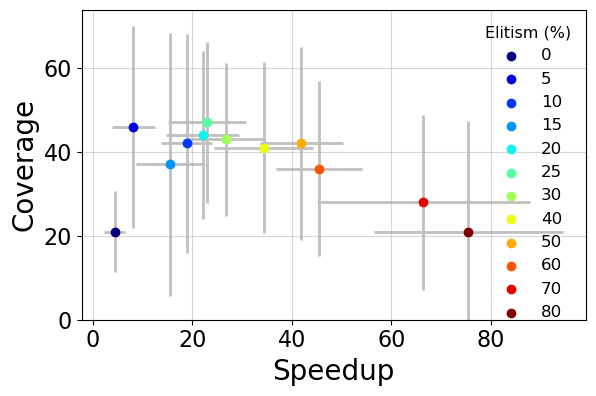

In [14]:
labels = ['0', '5', '10', '15', '20', '25', '30', '40', '50', '60', '70', '80']
plot_coverage_vs_speedup(med_speedup , med_coverage, speedup_std, coverage_std, 'elitism', 'Elitism (%)', labels)